In [1]:
import numpy as np
import pandas as pd

from servo_positioning_system_chatgpt import simulate_servo_positioning_system
import matplotlib.pyplot as plt
from control.matlab import *
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
# random signal generation
def prbs(nstep):
    # a_range = [0,2]
    # a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
    
    b_range = [50, 500]
    b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0
    
    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]
        
    # PRBS
    a = np.zeros(nstep)
    j = 0
    while j < nstep:
        a[j] = 10
        a[j+1] = -10
        j = j+2
    
    i=0
    prbs = np.zeros(nstep)
    while b[i]<np.size(prbs):
        k = b[i]
        prbs[k:] = a[i]
        i=i+1
        
    return prbs

In [3]:
# nstep = 300
# 
# # random signal generation
# 
# a_range = [0,2]
# a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
# 
# b_range = [2, 10]
# b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
# b = np.round(b)
# b = b.astype(int)
# 
# b[0] = 0
# 
# for i in range(1,np.size(b)):
#     b[i] = b[i-1]+b[i]
# 
# # Random Signal
# i=0
# random_signal = np.zeros(nstep)
# while b[i]<np.size(random_signal):
#     k = b[i]
#     random_signal[k:] = a[i]
#     i=i+1
# 
# # PRBS
# a = np.zeros(nstep)
# j = 0
# while j < nstep:
#     a[j] = 5
#     a[j+1] = -5
#     j = j+2
# 
# i=0
# prbs = np.zeros(nstep)
# while b[i]<np.size(prbs):
#     k = b[i]
#     prbs[k:] = a[i]
#     i=i+1
# 
# plt.figure(0) 
# plt.subplot(2,1,1)
# plt.plot(random_signal, drawstyle='steps',label='Random Signal')
# plt.legend()
# plt.subplot(2,1,2)
# plt.plot(prbs, drawstyle='steps', label='PRBS')
# plt.legend()
# plt.show()

In [4]:
n_u = 1
n_x = 3
n_y = 1

u_std = 5
perturbation = 0.25 # each param can vary of perturbation %

Ts = 1e-4 # must be small otherwise RK diverges
Ts_downsampled = 1e-2
T = Ts_downsampled * 500

t = np.arange(0, T, Ts)
t_downsampled = np.arange(0, T, Ts_downsampled)
# input signal
u_s = np.array([1e-3])



#u = u_std * np.random.randn(*t.shape,n_u) + u_s
u = np.zeros((len(t), 1))
u[:, 0] = prbs(len(t)) + u_s[0]
# output signal
x, u, y, _ = simulate_servo_positioning_system(Ts, u, perturbation=perturbation)

# Desired variable to be controlled is x1 = \theta. Let's compute virtual error
s = tf('s')
tau = 5  # 2 sec t. ass
M = 1 / (1 + (tau / (2 * np.pi)) * s)
M = c2d(M, Ts)
z = tf('z')
y_downsampled = y[::int(Ts_downsampled/Ts), 0]
r_v = lsim((z * M) ** (-1), y_downsampled, t[::int(Ts_downsampled/Ts)])[0]

e_v = (r_v - y_downsampled).reshape(-1,1)  # must be 2d
u = u[::int(Ts_downsampled/Ts)]
x = x[::int(Ts_downsampled/Ts)]
y = y[::int(Ts_downsampled/Ts)]

C:\Users\ricca\anaconda3\envs\sysid-transformers-control\Lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


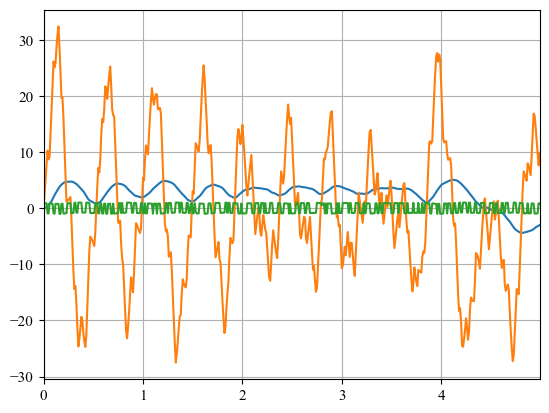

In [5]:
plt.plot(t_downsampled, y)

In [6]:
N = 50 # n. of test experiments

u_test = np.zeros((N, *u.shape))
e_v_test = np.zeros((N, *u.shape))
x_test = np.zeros((N, *x.shape))   # state with process noise
y_test = np.zeros((N, *y.shape))   # output with measurement noise (we assume n_y=2)

data_test = [None] * N

for i in range(N): # generate N I/O sets of data 
    u = np.zeros((len(t), 1))
    u[:, 0] = prbs(len(t)) + u_s[0]
    u_test[i,:,:] = u[::int(Ts_downsampled/Ts)]
    # we need to shift the vector u: currently is u_t,...u_t+k, it must become u_{t-1},....u_{t+k-1}
    u_test[i,1:,:] = u_test[i,:-1,:]
    u_test[i,0,:] = 1e-3
    # u_test[i,:,:] = u_std * np.random.randn(*t.shape,n_u) + u_s
    # u_test[i,:,:] = u
    # output signal
    x, _, y, data = simulate_servo_positioning_system(Ts, u, perturbation=perturbation, save_params=True, process_noise=True)
    
    data_test[i] = dict(data)
    
    y_downsampled = y[::int(Ts_downsampled/Ts), 0]
    r_v = lsim((z * M) ** (-1), y_downsampled, t[::int(Ts_downsampled/Ts)])[0]
    
    e_v_test[i,:,:] = (r_v - y_downsampled).reshape(-1,1)  # must be 2d
    u = u[::int(Ts_downsampled/Ts)]

    y_test[i,:,:] = y[::int(Ts_downsampled/Ts)]
    x_test[i,:,:] = x[::int(Ts_downsampled/Ts)]

C:\Users\ricca\anaconda3\envs\sysid-transformers-control\Lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


In [4]:
import numpy as np
import torch
a = np.ones(5)
b = np.cumsum(a)
torch.Tensor([a, b])

C:\Users\ricca\AppData\Local\Temp\ipykernel_24184\3393762821.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  torch.Tensor([a, b])


tensor([[1., 1., 1., 1., 1.],
        [1., 2., 3., 4., 5.]])

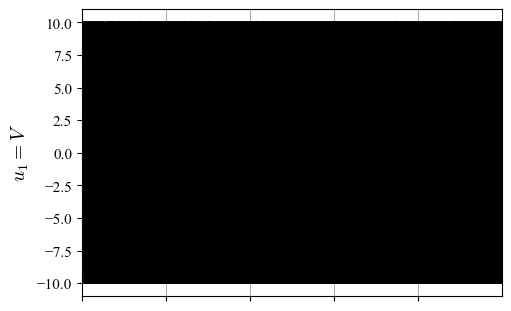

In [7]:
plt.figure(figsize=(5,3), constrained_layout=True)

ax1 = plt.subplot(111)
plt.plot(t_downsampled, u_test[:,:,0].T, c='k', alpha=0.3, linewidth=1)
plt.tick_params('x', labelbottom=False)
plt.ylabel(r'$u_1 = V$')

plt.show()

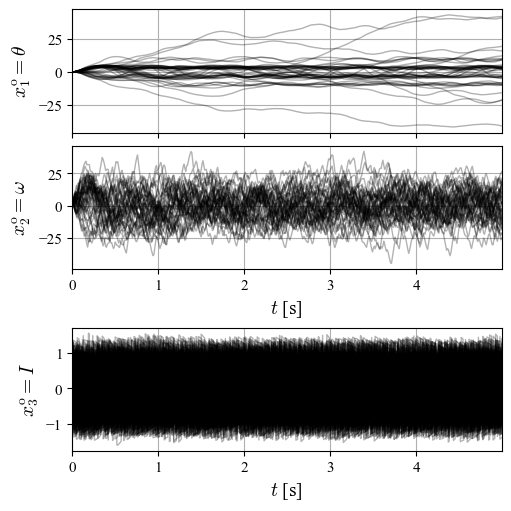

In [8]:
plt.figure(figsize=(5,5), constrained_layout=True)

ax1 = plt.subplot(311)
plt.plot(t_downsampled, x_test[:,:,0].T, c='k', alpha=0.3, linewidth=1)
plt.tick_params('x', labelbottom=False)
plt.ylabel(r'$x^{\mathrm{o}}_1 = \theta$')

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_downsampled, x_test[:,:,1].T, c='k', alpha=0.3, linewidth=1)
plt.ylabel('$x^{\mathrm{o}}_2 = \omega$')
plt.xlabel('$t$ [s]')

ax2 = plt.subplot(313, sharex=ax1)
plt.plot(t_downsampled, x_test[:,:,2].T, c='k', alpha=0.3, linewidth=1)
plt.ylabel('$x^{\mathrm{o}}_3 = I$')
plt.xlabel('$t$ [s]')

# plt.tight_layout()

# plt.savefig('meta_set.pdf')

plt.show()

In [9]:
import pickle as pkl
from typing import Dict

test_set = {'t':t, 'u_test':u_test, 'x_test':x_test, 'y_test':y_test, 'data_test': data_test}
with open('../data/control/test_set_prbs.pkl', 'wb') as f:
    pkl.dump(test_set, f)

In [10]:
u_test[:,0,:]

array([[0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001]])